# Traffic Light Detection and Classification - Udacity CarND Capstone
Using a pre-trained model to detect objects in an image.

In [34]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

## Object detection imports

Here are the imports from the object detection module.

In [35]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Model preparation

In [36]:
ssd_inception_sim_model = 'frozen_models/frozen_sim_inception/frozen_inference_graph.pb'
ssd_inception_real_model = 'frozen_models/frozen_real_inception_6561/frozen_inference_graph.pb'
faster_rcnn_sim_model = 'frozen_models/faster_rcnn_frozen_sim/frozen_inference_graph.pb'
faster_rcnn_real_model = 'frozen_models/faster_rcnn_frozen_real/frozen_inference_graph.pb'

trained_model = 'frozen_sim/frozen_inference_graph.pb'



PATH_TO_ROOT = r'C:/Users/saidz/git/CarND-Capstone/tl_detection_pipeline/'


PATH_TO_LABELS = r'C:/Users/saidz/tensorflow/models/research/object_detection/data/mscoco_label_map.pbtxt'
NUM_CLASSES = 13
NUM_CLASSES = 90

os.chdir(PATH_TO_ROOT)

M = "INCEPTION"
M = "FASTER"

if (M == "FASTER"):
    PATH_TO_MODEL = PATH_TO_ROOT + r'annotation_pipeline_data/faster_rcnn_resnet101_coco_2018_01_28/frozen_inference_graph.pb'
    !python c:/users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py --pipeline_config_path=annotation_pipeline_data/faster_rcnn_resnet101_coco.config --trained_checkpoint_prefix=annotation_pipeline_data/faster_rcnn_resnet101_coco_2018_01_28/model.ckpt --output_directory=frozen_sim_faster/
    PATH_TO_MODEL = PATH_TO_ROOT + r'frozen_sim_faster/frozen_inference_graph.pb'
elif (M == "INCEPTION"):
    PATH_TO_MODEL = PATH_TO_ROOT + r'annotation_pipeline_data/ssd_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
    !python c:/users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py --pipeline_config_path=annotation_pipeline_data/ssd_inception_v2_coco.config --trained_checkpoint_prefix=annotation_pipeline_data/ssd_inception_v2_coco_2018_01_28/model.ckpt --output_directory=frozen_sim_inception/
    PATH_TO_MODEL = PATH_TO_ROOT + r'frozen_sim_inception/frozen_inference_graph.pb'
elif (M == "MOBILENET"):
    PATH_TO_MODEL = PATH_TO_ROOT + r'annotation_pipeline_data/ssd_mobilenet_v1_coco_2018_03_29/frozen_inference_graph.pb'
    !python c:/users/saidz/tensorflow/models/research/object_detection/export_inference_graph.py --pipeline_config_path=annotation_pipeline_data/ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix=annotation_pipeline_data/ssd_mobilenet_v1_coco_2018_03_29/model.ckpt --output_directory=frozen_sim_mobilenet/
    PATH_TO_MODEL = PATH_TO_ROOT + r'frozen_sim_mobilenet/frozen_inference_graph.pb'


Converted 530 variables to const ops.


Instructions for updating:
Please switch to tf.train.get_or_create_global_step
2019-12-07 20:55:13.306777: I C:\tf_jenkins\home\workspace\rel-win\M\windows\PY\35\tensorflow\core\platform\cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-12-07 20:55:26.834720: I C:\tf_jenkins\home\workspace\rel-win\M\windows\PY\35\tensorflow\core\grappler\devices.cc:51] Number of eligible GPUs (core count >= 8): 0


## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 2, we know that this corresponds to Red. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [37]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

In [38]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [39]:
from glob import glob

## Detection

## 1. Testing SSD Inception Models

### 1.1 Testing model trained on simulator on simulator images

In [40]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [41]:
print("detection_model.image_tensor: ")
print(detection_graph.get_tensor_by_name('image_tensor:0'), "\n")
print("detection_model.detection_boxes: ")
print(detection_graph.get_tensor_by_name('detection_boxes:0'), "\n")
print("detection_model.detection_scores: ")
print(detection_graph.get_tensor_by_name('detection_scores:0'), "\n")
print("detection_model.detection_classes: ")
print(detection_graph.get_tensor_by_name('detection_classes:0'), "\n")
print("detection_model.num_detections: ")
print(detection_graph.get_tensor_by_name('num_detections:0'), "\n")

detection_model.image_tensor: 
Tensor("image_tensor:0", shape=(?, ?, ?, 3), dtype=uint8) 

detection_model.detection_boxes: 
Tensor("detection_boxes:0", dtype=float32) 

detection_model.detection_scores: 
Tensor("detection_scores:0", dtype=float32) 

detection_model.detection_classes: 
Tensor("detection_classes:0", dtype=float32) 

detection_model.num_detections: 
Tensor("num_detections:0", dtype=float32) 



In [42]:
PATH_TO_TEST_IMAGES_DIR = 'C:/Users/saidz/git/TrafficLight_Detection-TensorFlowAPI/test_images_sim/'
PATH_TO_TEST_IMAGES_DIR = 'raw-images-simulation/'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

raw-images-simulation/*.jpg
Length of test images: 11


Image size is:  (800, 600)


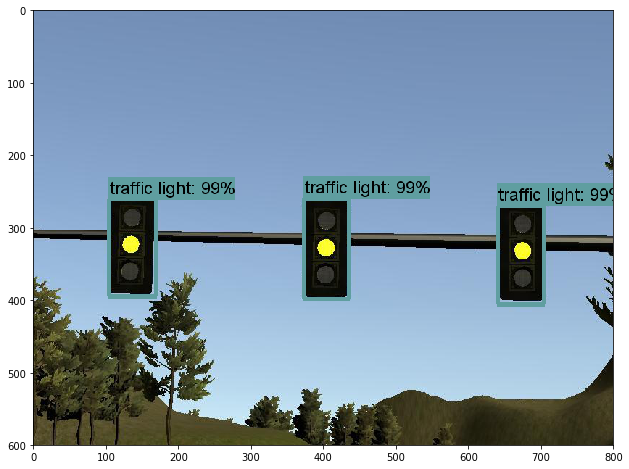

traffic light 0.998111
Distance (metres) 0.0
Time in milliseconds 21115.431308746338 

traffic light 0.99782
Distance (metres) 0.0
Time in milliseconds 21115.431308746338 

traffic light 0.997086
Distance (metres) 0.0
Time in milliseconds 21115.431308746338 

Image size is:  (800, 600)


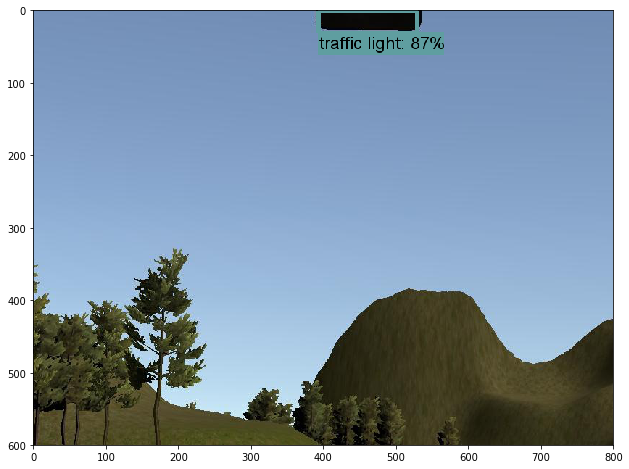

traffic light 0.872614
Distance (metres) 0.0
Time in milliseconds 15539.735794067383 

Image size is:  (800, 600)


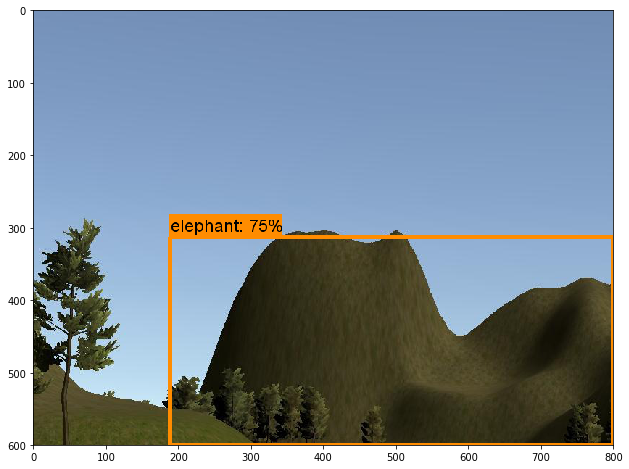

elephant 0.752767
Distance (metres) 0.0
Time in milliseconds 15507.37977027893 

Image size is:  (800, 600)


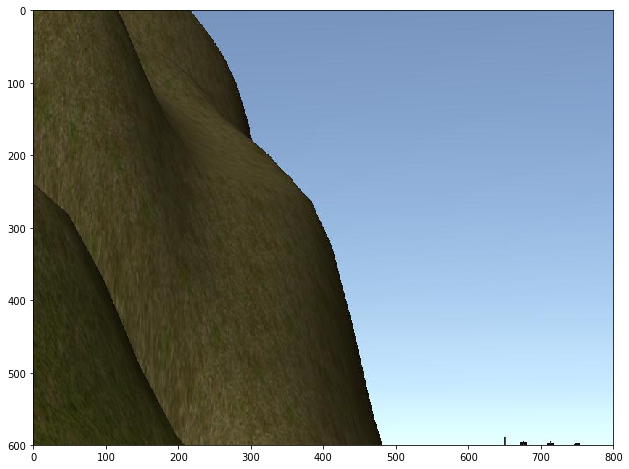

Image size is:  (800, 600)


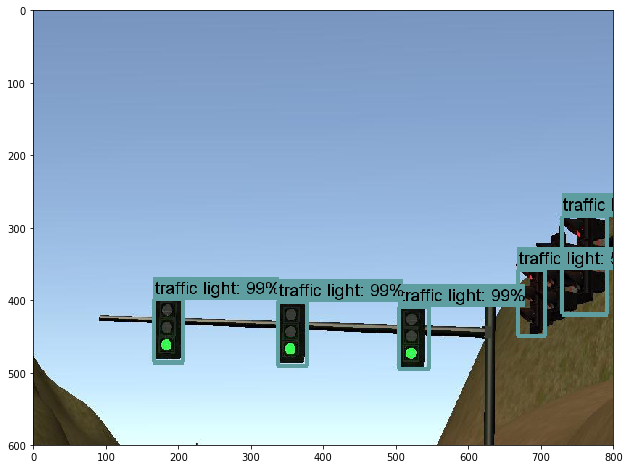

traffic light 0.996827
Distance (metres) 0.0
Time in milliseconds 15374.253034591675 

traffic light 0.996408
Distance (metres) 0.0
Time in milliseconds 15374.253034591675 

traffic light 0.992936
Distance (metres) 0.0
Time in milliseconds 15374.253034591675 

traffic light 0.629128
Distance (metres) 0.0
Time in milliseconds 15374.253034591675 

traffic light 0.508549
Distance (metres) 0.0
Time in milliseconds 15374.253034591675 

Image size is:  (800, 600)


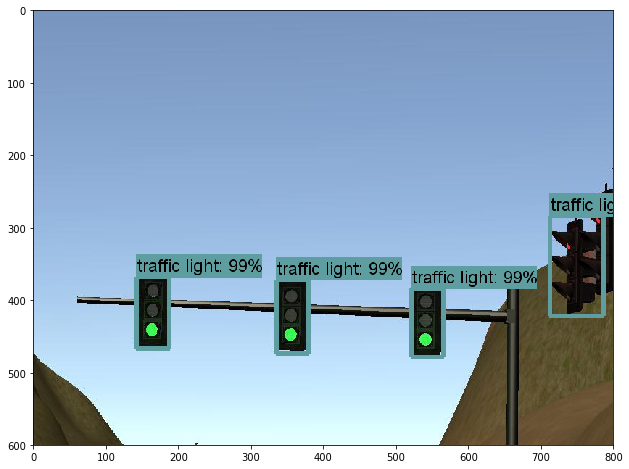

traffic light 0.997847
Distance (metres) 0.0
Time in milliseconds 15565.293073654175 

traffic light 0.99655
Distance (metres) 0.0
Time in milliseconds 15565.293073654175 

traffic light 0.995748
Distance (metres) 0.0
Time in milliseconds 15565.293073654175 

traffic light 0.970804
Distance (metres) 0.0
Time in milliseconds 15565.293073654175 

Image size is:  (800, 600)


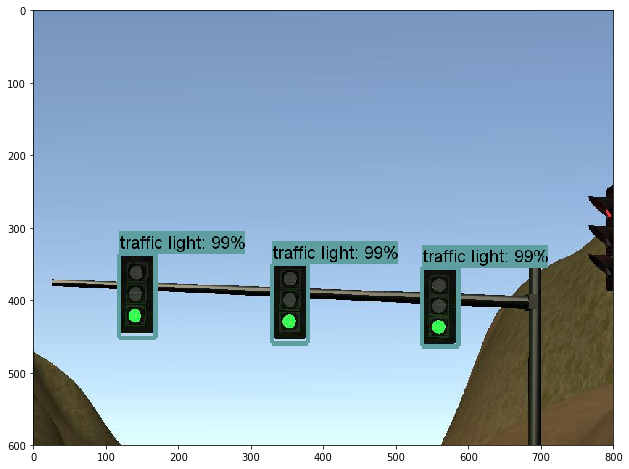

traffic light 0.99794
Distance (metres) 0.0
Time in milliseconds 15376.961469650269 

traffic light 0.996658
Distance (metres) 0.0
Time in milliseconds 15376.961469650269 

traffic light 0.995139
Distance (metres) 0.0
Time in milliseconds 15376.961469650269 

Image size is:  (800, 600)


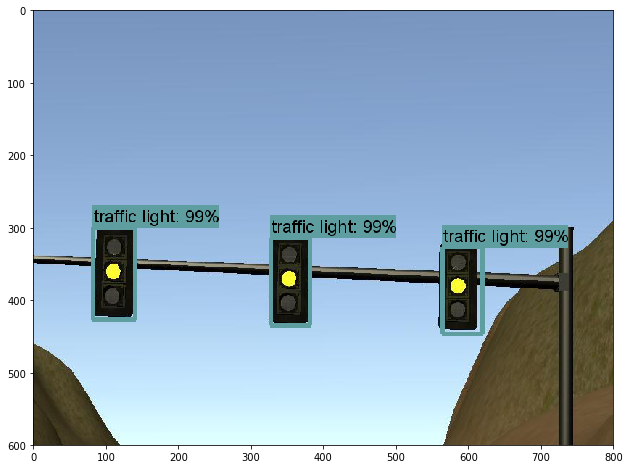

traffic light 0.996954
Distance (metres) 0.0
Time in milliseconds 15405.223369598389 

traffic light 0.996843
Distance (metres) 0.0
Time in milliseconds 15405.223369598389 

traffic light 0.995302
Distance (metres) 0.0
Time in milliseconds 15405.223369598389 

Image size is:  (800, 600)


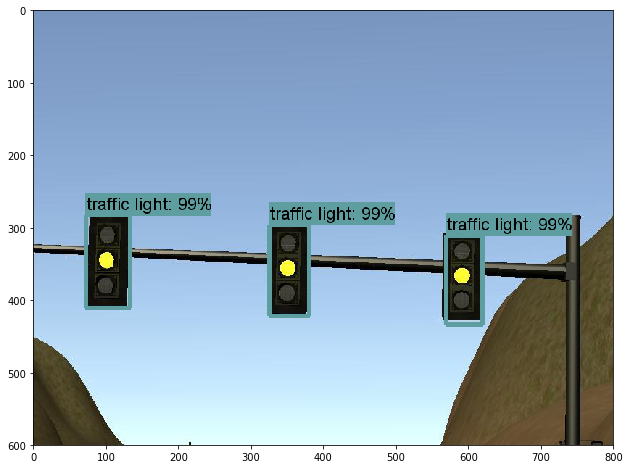

traffic light 0.996241
Distance (metres) 0.0
Time in milliseconds 15393.826007843018 

traffic light 0.995971
Distance (metres) 0.0
Time in milliseconds 15393.826007843018 

traffic light 0.99569
Distance (metres) 0.0
Time in milliseconds 15393.826007843018 

Image size is:  (800, 600)


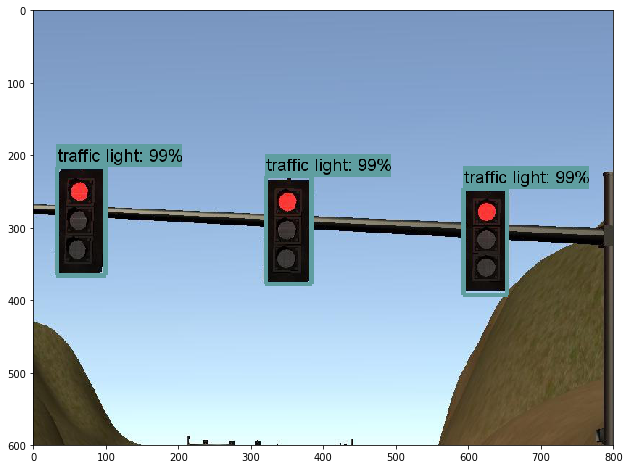

traffic light 0.998127
Distance (metres) 0.0
Time in milliseconds 15364.24970626831 

traffic light 0.997495
Distance (metres) 0.0
Time in milliseconds 15364.24970626831 

traffic light 0.99643
Distance (metres) 0.0
Time in milliseconds 15364.24970626831 

Image size is:  (800, 600)


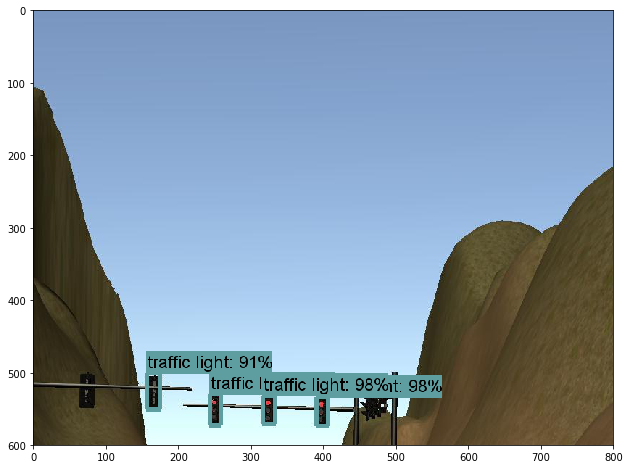

traffic light 0.993268
Distance (metres) 0.0
Time in milliseconds 15546.059370040894 

traffic light 0.988049
Distance (metres) 0.0
Time in milliseconds 15546.059370040894 

traffic light 0.981518
Distance (metres) 0.0
Time in milliseconds 15546.059370040894 

traffic light 0.910233
Distance (metres) 0.0
Time in milliseconds 15546.059370040894 



In [43]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            print("Image size is: ", image.size)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n") 

### 1.2 Testing model trained on real images on Real World images

In [ ]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(ssd_inception_real_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
PATH_TO_TEST_IMAGES_DIR = 'test_images_udacity'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [ ]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  1345.200806
                    fy =  1353.838257
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")

## 2. Testing Faster RCNN Models

### 2.1 Testing model trained on simulator on simulator images

In [ ]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(faster_rcnn_sim_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
PATH_TO_TEST_IMAGES_DIR = 'test_images_sim'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [ ]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n") 

### 2.2 Testing model trained on real images on Real World images

In [ ]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(faster_rcnn_real_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [ ]:
PATH_TO_TEST_IMAGES_DIR = 'test_images_udacity'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [ ]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  1345.200806
                    fy =  1353.838257
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")